In [0]:
#####################################################
###### UPLOAD LOCAL FILE TO WORKING DIRECTORY #######
#####################################################

#from google.colab import files
#uploaded = files.upload()

Saving data.zip to data.zip


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 16 12:36:30 2019
@author: William Nadolski (winado)
Created based on the following tutorial: http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
"""
##################################
### INSTALL NECESSARY PACKAGES ###
##################################

#If first time running then execute the following from OS command line
#Additional options are necessary for installing from within Jupyter

#import os
#import sys
#!{sys.executable} -m pip install --user siml
#!{sys.executable} -m pip install --user xgboost
#!{sys.executable} -m pip install --user seaborn
#!{sys.executable} -m pip install --user pywavelets
#!{sys.executable} -m pip install --user tensorflow-gpu
#!{sys.executable} -m pip install --user keras

  Created wheel for siml: filename=siml-0.2.1-cp36-none-any.whl size=19879 sha256=06f93967e15cf10b3c6f5d4ec7c5f41c94e16052784c470b0cf097f1c8706e19
  Stored in directory: /root/.cache/pip/wheels/f2/8d/36/68e58ff0a4b13cd5f2aa666139adf7213afb58781849b0044a
Successfully built siml


In [0]:
#################################
### IMPORT NECESSARY PACKAGES ###
#################################

#%% IMPORT NECESSARY PACKAGES

import os
import sys
import glob
import pywt
import time
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#matplotlib.use("TkAgg")
import numpy as np
import tensorflow as tf
from collections import defaultdict, Counter
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
 
import keras
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.layers import LeakyReLU
history = History()
 
#Check to see whether TF is utilizing GPU or CPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16570092551011651856
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7388938946905628355
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15664847874277106190
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8705745639190423045
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
#################################
#### CONNECT TO GOOGLE DRIVE ####
#################################

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
##########################
#### LIST DIRECTORIES ####
##########################

import glob
path = '/content/gdrive/My Drive/data/'
folders = [f for f in glob.glob(path + "**/", recursive=True)]
for f in folders:
    print(f)

/content/gdrive/My Drive/data/
/content/gdrive/My Drive/data/UCI HAR Dataset/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/Inertial Signals/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/
/content/gdrive/My Drive/data/Stitched/
/content/gdrive/My Drive/data/Stitched/test/
/content/gdrive/My Drive/data/Stitched/test/sitting/
/content/gdrive/My Drive/data/Stitched/test/walking_upstairs/
/content/gdrive/My Drive/data/Stitched/test/walking/
/content/gdrive/My Drive/data/Stitched/test/walking_downstairs/
/content/gdrive/My Drive/data/Stitched/test/laying/
/content/gdrive/My Drive/data/Stitched/test/standing/
/content/gdrive/My Drive/data/Stitched/train/
/content/gdrive/My Drive/data/Stitched/train/standing/
/content/gdrive/My Drive/data/Stitched/train/walking/
/content/gdrive/My Drive/data/Stitched/train/sitting/
/content/gdrive/My Drive/data/Stitched/train/l

In [0]:
#%% IMPORT STITCHED HAR SPECTROGRAM IMAGES

activity_labels = ['walking', 'walking_upstairs', 'walking_downstairs', 'sitting', 'standing', 'laying']
label_values = [ 0, 1, 2, 3, 4, 5 ]
class_levels = len(label_values)

img_dir_train='/content/gdrive/My Drive/data/Stitched/train/'
img_dir_test='/content/gdrive/My Drive/data/Stitched/test/'

train_images, train_labels = [] , []
test_images, test_labels = [] , []

#Resize image dimensions to be
height = 128
width = 128
depth = 3
 
#Load images and activity labels from folder path
def load_images_from_folder(folder):
    images = []
    labels = []
    for ii in range(0,class_levels):
        activity = activity_labels[ii]
        value = label_values[ii]
        subpath = (folder + activity + '/')
        print("iteration #{}".format(ii))
        print("label value is: {}".format(value))
        print("activity label: {}".format(activity))
        print("reading images from: {}".format(subpath))
        for filename in os.listdir(subpath):
            filepath = os.path.join(subpath,filename)
            #print(filepath)
            img = mpimg.imread(filepath)
            img = resize(img, (width,height,depth), anti_aliasing=True)
            images.append(img)
            labels.append(value)
    return images, labels

test_images, test_labels = load_images_from_folder(img_dir_test) #Load test images by label (based on subdir)
test_images = np.stack(test_images,axis=0) #Reshape list of 3D arrays into single 4D array

train_images, train_labels = load_images_from_folder(img_dir_train) #Load test images by label (based on subdir)
train_images = np.stack(train_images,axis=0) #Reshape list of 3D arrays into single 4D array

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

#Shuffle data while retaining mapping with labels
train_images, train_labels = randomize(train_images, np.array(train_labels))
test_images, test_labels = randomize(test_images, np.array(test_labels))

iteration #0
label value is: 0
activity label: walking
reading images from: /content/gdrive/My Drive/data/Stitched/test/walking/
iteration #1
label value is: 1
activity label: walking_upstairs
reading images from: /content/gdrive/My Drive/data/Stitched/test/walking_upstairs/
iteration #2
label value is: 2
activity label: walking_downstairs
reading images from: /content/gdrive/My Drive/data/Stitched/test/walking_downstairs/
iteration #3
label value is: 3
activity label: sitting
reading images from: /content/gdrive/My Drive/data/Stitched/test/sitting/
iteration #4
label value is: 4
activity label: standing
reading images from: /content/gdrive/My Drive/data/Stitched/test/standing/
iteration #5
label value is: 5
activity label: laying
reading images from: /content/gdrive/My Drive/data/Stitched/test/laying/
iteration #0
label value is: 0
activity label: walking
reading images from: /content/gdrive/My Drive/data/Stitched/train/walking/
iteration #1
label value is: 1
activity label: walking_u

In [0]:
#%%PREP DATA FOR CNN USING KERAS

Ytrain = list(train_labels[:len(train_labels)])
Ytest = list(test_labels[:len(test_labels)])

input_shape = (width, height, depth)

#convert the data to the right type
Xtrain = train_images.astype('float32')
Xtest = test_images.astype('float32')

print('Xtrain shape:', Xtrain.shape)
print(Xtrain.shape[0], 'train samples')
print(Xtest.shape[0], 'test samples')

#convert class vectors to binary class matrices - this is for use in categorical_crossentropy loss below
Ytrain = keras.utils.to_categorical(train_labels, class_levels)
Ytest = keras.utils.to_categorical(test_labels, class_levels)

Xtrain shape: (7899, 128, 128, 3)
7899 train samples
2400 test samples


In [0]:
#%%BUILD AND TRAIN CNN MODEL USING ONLY CWT FEATURES (SPECTROGRAM IMAGES)

#Specify hyperparameters (may need to tune to optimize performance)
def train_CNN(batch_size=64, epochs=100, lr=0.001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.025))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.025))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(class_levels, activation='softmax'))
 
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=lr, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

    model.fit(Xtrain, Ytrain, batch_size=batch_size,
              epochs=epochs, verbose=1,
              validation_data=(Xtest, Ytest),
              callbacks=[history])

    train_score = model.evaluate(Xtrain, Ytrain, verbose=0)
    print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    test_score = model.evaluate(Xtest, Ytest, verbose=0)
    print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

#Plot model performance over all epochs
def plot_epochs(epochs):
    fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
    axarr[0].plot(range(1, epochs+1), history.history['acc'], label='train score')
    axarr[0].plot(range(1, epochs+1), history.history['val_acc'], label='test score')
    axarr[0].set_xlabel('Number of Epochs', fontsize=18)
    axarr[0].set_ylabel('Accuracy', fontsize=18)
    axarr[0].set_ylim([0,1])
    axarr[1].plot(range(1, epochs+1), history.history['acc'], label='train score')
    axarr[1].plot(range(1, epochs+1), history.history['val_acc'], label='test score')
    axarr[1].set_xlabel('Number of Epochs', fontsize=18)
    axarr[1].set_ylabel('Accuracy', fontsize=18)
    axarr[1].set_ylim([0.75,1])
    plt.legend()
    plt.show()

W0806 15:41:11.110976 139842235275136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 15:41:11.114266 139842235275136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 15:41:11.128478 139842235275136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 15:41:11.163013 139842235275136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0806 15:41:11.165860 139842235275136 deprecation_wrapp

Train on 7899 samples, validate on 2400 samples
Epoch 1/100
7899/7899 [==============================] - 19s 2ms/step - loss: 0.8736 - acc: 0.7325 - val_loss: 0.3441 - val_acc: 0.8550
Epoch 2/100
7899/7899 [==============================] - 12s 1ms/step - loss: 0.3370 - acc: 0.8615 - val_loss: 0.2654 - val_acc: 0.8925
Epoch 3/100
7899/7899 [==============================] - 12s 1ms/step - loss: 0.2665 - acc: 0.8916 - val_loss: 0.2470 - val_acc: 0.8975
Epoch 4/100
7899/7899 [==============================] - 11s 1ms/step - loss: 0.2218 - acc: 0.9125 - val_loss: 0.2403 - val_acc: 0.9050
Epoch 5/100
7899/7899 [==============================] - 12s 1ms/step - loss: 0.1869 - acc: 0.9239 - val_loss: 0.2319 - val_acc: 0.9017
Epoch 6/100
7899/7899 [==============================] - 12s 1ms/step - loss: 0.1505 - acc: 0.9404 - val_loss: 0.2195 - val_acc: 0.9067
Epoch 7/100
7899/7899 [==============================] - 12s 1ms/step - loss: 0.1283 - acc: 0.9486 - val_loss: 0.2087 - val_acc: 0.9129


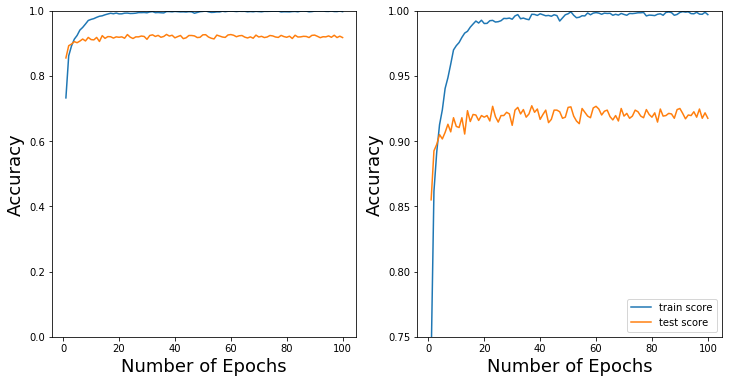

In [0]:
#TRAIN CNN MODEL
train_CNN(batch_size=64, epochs=100, lr=0.001)
plot_epochs(epochs=100)